In [1]:
from pymongo import MongoClient
from sshtunnel import SSHTunnelForwarder
import pprint
from bson.objectid import ObjectId
import pyperclip as clip
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools as it
# from datasu import auc
# import pixiedust
# clip.copy(json.dumps(m1['msg']))
import nbimporter
from common_functions import *
pd.options.mode.chained_assignment = None  # default='warn'


Importing Jupyter notebook from common_functions.ipynb


In [ ]:
notebook_name = 'STS1-v1.2'

### funcs

In [2]:
bert_metadata = {            
    'version': '1.0',
    'encoder': 'BERT',
    'model': 'uncased_L-24_H-1024_A-16',    
    'max_seq_len': 80,
    'pooling_strategy': 'REDUCE_MEAN', 
    'pooling_layer': '-2',
    'dimensions': 1024
}
bert_embedding_index = 2

def get_fields_for_vector(message):    
    f = {}
    msg = message['msg']
    f['text'] = msg['text']    
    f['text_emb_bert'] = np.array(message['embs']['text'][bert_embedding_index]['vector'])
#     f['positive_aspects'] = 'zzz'#msg['positive_aspects']
    return list(f.items())

### load data

In [8]:
# MONGO_HOST = "ec2-52-23-187-115.compute-1.amazonaws.com"
# MONGO_DB = "marketpulzz"
# server = SSHTunnelForwarder(
#     MONGO_HOST,
#     ssh_username='ubuntu',
#     ssh_pkey="/Users/sasha/.ssh/mmuze.pem",
# #     ssh_private_key_password="secret",
#     remote_bind_address=('127.0.0.1', 27017),
#     local_bind_address=('127.0.0.1', 63327),
#     set_keepalive = 5,
# )

# server.start()
# client = MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port
# db = client[MONGO_DB]

In [3]:
MONGO_DB = "marketpulzz"
client = MongoClient('127.0.0.1', 27017)
db = client[MONGO_DB]

In [4]:
def get_message_for_master_tag(mt):   
    mess = db.genie_conversation_messages_emb.find_one({"_id": mt['conversation_message_id']})
    fields = get_fields_for_vector(mess)    
#     def extr_intent(intent):
#         row = {**{'intent':intent['name'], 'tag':intent['tag']}, **dict(fields)}   
#         retun 
    intents = mt['intents']
    rows = list(map(lambda intent:{**{'intent':intent['name'], 'tag':intent['tag']}, **dict(fields)}, intents))
    return rows
    
master_tags_cursor = db.genie_master_tags.find({"intents.0":{'$exists':True}})
data = list(it.chain(*map(get_message_for_master_tag, master_tags_cursor)))

### encode data

In [5]:
df_data_all_unfiltered = pd.DataFrame(data)
df_data_all = df_data_all_unfiltered
df_data_all = df_data_all_unfiltered.loc[df_data_all_unfiltered.tag=='true']#.copy()
df_data_all.drop(columns=['tag'],inplace=True)
# df_data_all[0:150]['intent'] = 'refund'
# df_data_all[0:150]['text'] = 'I want my money back as soon as possible. Thanks'
df_data_all.head()

,intent,text,text_emb_bert
0,More,more,"[-0.04778273403644562, -0.39900097250938416, -..."
21,More,more option,"[-0.2991718649864197, -0.037089668214321136, -..."
22,More,more options,"[-0.36747345328330994, -0.5106234550476074, -0..."
23,More,more options please,"[-0.005186713766306639, -0.982321560382843, -0..."
26,More,More products,"[-0.48683393001556396, -0.0504351444542408, -0..."


### init encoders

##### BERT

In [6]:
#bert-serving-start -model_dir /Users/sasha/dev/mmuze/_models/BERT/uncased_L-24_H-1024_A-16/ -num_worker=1 -max_batch_size 1000 -max_seq_len 200 -pooling_strategy REDUCE_MEAN -pooling_layer -1 -2 
_models_path = '/Users/sasha/dev/mmuze/_models/BERT'
BERT_BASE_DIR=f'{_models_path}/uncased_L-24_H-1024_A-16/'

In [7]:
from bert_serving.client import BertClient
# bc = BertClient()

In [61]:
# %%time
# text_emb_bert = bc.encode(list(df_data_all['text'].values))
# df_data_all['text_emb_bert'] = list(text_emb_bert)

##### USE

In [24]:
# https://stackoverflow.com/questions/48092772/add-operation-to-graph-without-with-as-clause
import tensorflow_hub as hub
graph = tf.Graph()
cm = graph.as_default()   
cm.__enter__()
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" 
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" 
#@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url, trainable=True)

session = tf.Session(graph=graph)
session.run(tf.global_variables_initializer())
session.run(tf.tables_initializer())
input1 = tf.placeholder(tf.string, shape=(None))
emb = embed(input1)


def encode_USE(texts):   
    emb1 = session.run([emb], feed_dict={ input1: texts })
    return emb1

#warm up
_ = encode_USE(["sasha", "miko"])

INFO:tensorflow:Using /var/folders/xn/dh4vn2gx4x36vh0x051kpw1m0000gn/T/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
use_metadata = {
    'model': module_url,
    'dimensions': 1024
}

In [25]:
%%time
text_emb_USE = encode_USE(df_data_all['text'].values)[0]
df_data_all['text_emb_use'] = list(text_emb_USE)

CPU times: user 6min 44s, sys: 49.7 s, total: 7min 34s
Wall time: 1min 5s


In [6]:
df_data_all.head()

,intent,text,text_emb_bert
0,More,more,"[-0.04778273403644562, -0.39900097250938416, -..."
21,More,more option,"[-0.2991718649864197, -0.037089668214321136, -..."
22,More,more options,"[-0.36747345328330994, -0.5106234550476074, -0..."
23,More,more options please,"[-0.005186713766306639, -0.982321560382843, -0..."
26,More,More products,"[-0.48683393001556396, -0.0504351444542408, -0..."


### evaluation

In [10]:
pipeline = [
{'$unwind': '$intents'},
{'$project' : {'_id': 0, 'intents.name' : 1 , 'intents.category' : 1, 'intents.tag' : 1 } },
{'$group' : {
       '_id' : { 
            'name': "$intents.name", 
            'category': '$intents.category', 
            'tag': '$intents.tag' 
        },
        'name': {'$first': "$intents.name"}, 
        'category': {'$first':'$intents.category'}, 
        'tag': {'$first':'$intents.tag'},      
        'count': { '$sum': 1 }
    }
},
{'$project' : {'_id': 0, 'name' : 1 , 'category' : 1, 'tag' : 1,'count' : 1 }}
]

master_tag_stats = list(db.genie_master_tags.aggregate(pipeline))
df_master_tag_stats = pd.DataFrame(master_tag_stats, columns=['category','name','tag','count'])
df_master_tag_stats.pivot(index='name',values=['count'],columns='tag')

count              
tag                          amb  false   true
name                                          
Add to Wishlist              NaN   18.0    4.0
Back                         NaN   29.0   17.0
Compare                      NaN   24.0    NaN
Complementary                NaN  105.0   63.0
Customer Support             1.0   26.0  631.0
Frustration                  8.0   97.0   13.0
Help                         NaN   48.0   16.0
Introduction                 NaN   17.0    8.0
More                        34.0   32.0   17.0
New Facecare Regimen         NaN  238.0   95.0
Order Information            NaN  116.0  367.0
Product Aspect Information   NaN  122.0   90.0
Product not found            NaN  128.0  396.0
Shop new arrivals            2.0    1.0    4.0

In [7]:
def smooth_intent_prob(w):
    return w*100 if w < 0.01 else w

# print("total count: ",df_data_all.shape[0])
# df_data_agg_by_intent = pd.DataFrame(df_data_all.groupby(['intent']).count()['tag'])
# df_data_agg_by_intent.rename(columns={'tag':'count'}, inplace=True)
# df_data_agg_by_intent['intent_prob'] = df_data_agg_by_intent/df_data_agg_by_intent.sum()
# df_data_agg_by_intent['intent_prob_smoothed'] = df_data_agg_by_intent['intent_prob'].apply(smooth_intent_prob)
# df_data_agg_by_intent

#calc intent pro
df_data_all['intent_prob'] = 1.0#df_data_all.groupby(['intent']).transform('count')['text']/df_data_all.shape[0]
# df_data_all['intent_prob_weighted'] = df_data_all.groupby(['intent']).transform('count')['text']/df_data_all.shape[0]
# df_data_all['intent_prob_smoothed'] = df_data_all['intent_prob'].apply(smooth_intent_prob)
print("max message length: ", df_data_all['text'].map(len).max())
df_data_all.head(n=5)

max message length:  962


,intent,text,text_emb_bert,intent_prob
0,More,more,"[-0.04778273403644562, -0.39900097250938416, -...",1.0
21,More,more option,"[-0.2991718649864197, -0.037089668214321136, -...",1.0
22,More,more options,"[-0.36747345328330994, -0.5106234550476074, -0...",1.0
23,More,more options please,"[-0.005186713766306639, -0.982321560382843, -0...",1.0
26,More,More products,"[-0.48683393001556396, -0.0504351444542408, -0...",1.0


In [8]:
N = 300
df_query = df_data_all.sample(n=N, weights='intent_prob',random_state=888)
# df_query = df_data_all.sample(n=N, weights='intent_prob',random_state=108)
df_query
df_data = df_data_all.drop(df_query.index)

df_query_stats = pd.DataFrame()
df_query_stats['data'] = df_data.groupby(['intent']).count()['text']
df_query_stats['query'] = df_query.groupby(['intent']).count()['text']
df_query_stats['query_TP'] = df_query_stats['query']*df_query_stats['data']
df_query_stats['Q/D ratio'] = round(df_query_stats['query']/df_query_stats['data'],3)


print(df_query_stats)
print("")
print(f"total: {len(df_data_all)} => query:{len(df_query)} + data:{len(df_data)}")
total_rows = len(df_query)*len(df_data)
total_TP = df_query_stats['query_TP'].sum()
print(f"total rows:{total_rows} => total TP:{total_TP} TP_ratio:{round(df_query_stats['query_TP'].sum()/total_rows, 2)}")

                            data  query  query_TP  Q/D ratio
intent                                                      
Add to Wishlist                3      1         3      0.333
Back                          16      1        16      0.062
Complementary                 54      9       486      0.167
Customer Support             522    109     56898      0.209
Frustration                   11      2        22      0.182
Help                          13      3        39      0.231
Introduction                   5      3        15      0.600
More                          14      3        42      0.214
New Facecare Regimen          75     20      1500      0.267
Order Information            296     71     21016      0.240
Product Aspect Information    79     11       869      0.139
Product not found            330     66     21780      0.200
Shop new arrivals              3      1         3      0.333

total: 1721 => query:300 + data:1421
total rows:426300 => total TP:102689 TP_ratio:0

In [10]:
# df_eval = df_crossjoin(df_query[['text','text_emb_bert', 'text_emb_use', 'intent']], df_data, suffixes=('_q', ''))
df_eval = df_crossjoin(df_query[['text', 'text_emb_bert', 'intent']], df_data, suffixes=('_q', ''))

df_eval['is_same_intent'] = (df_eval['intent_q'] == df_eval['intent']).values
print("total rows: ",df_eval.shape[0])
df_eval.head(n=5)

total rows:  426300


text_q  \
2188 0   Thank you so much. I will take a look at both ...   
     21  Thank you so much. I will take a look at both ...   
     26  Thank you so much. I will take a look at both ...   
     27  Thank you so much. I will take a look at both ...   
     33  Thank you so much. I will take a look at both ...   

                                           text_emb_bert_q          intent_q  \
2188 0   [-0.3189716935157776, -0.33314159512519836, -0...  Customer Support   
     21  [-0.3189716935157776, -0.33314159512519836, -0...  Customer Support   
     26  [-0.3189716935157776, -0.33314159512519836, -0...  Customer Support   
     27  [-0.3189716935157776, -0.33314159512519836, -0...  Customer Support   
     33  [-0.3189716935157776, -0.33314159512519836, -0...  Customer Support   

        intent                  text  \
2188 0    More                  more   
     21   More           more option   
     26   More         More products   
     27   More  More products please   
     33   More                  next   

                                             text_emb_bert  intent_prob  \
2188 0   [-0.04778273403644562, -0.39900097250938416, -...          1.0   
     21  [-0.2991718649864197, -0.037089668214321136, -...          1.0   
     26  [-0.48683393001556396, -0.0504351444542408, -0...          1.0   
     27  [-0.21839949488639832, -0.5167475938796997, -0...          1.0   
     33  [0.1387757509946823, -0.40534600615501404, -0....          1.0   

         is_same_intent  
2188 0            False  
     21           False  
     26           False  
     27           False  
     33           False

In [11]:
ev_results = []
def add_ev_res(res, encoder, metadata):  
    metric = [{'name':k, 'value':v} for k,v in z.items()][0]
    ev_res = {
        'notebook': notebook_name,
        'encoder':encoder,
        'emb_metadata': metadata, 
        'metric': metric
    }    
#     ev_res = {**exp, **res}    
    ev_results.append(ev_res)

#### evaluate BERT

In [12]:
%%time
angdist_bert, cossim_bert = sim_exact(np.stack(df_eval['text_emb_bert_q'].values), np.stack(df_eval['text_emb_bert'].values))
df_eval['angdist_bert'] = angdist_bert#.diagonal()
df_eval['cossim_bert'] = cossim_bert#.diagonal()
df_eval_by_angdist_bert = df_eval.sort_values(by=['angdist_bert'], ascending=False)[0:total_TP]
df_eval_by_angdist_bert.head()

CPU times: user 27.3 s, sys: 1min 33s, total: 2min
Wall time: 1min 4s


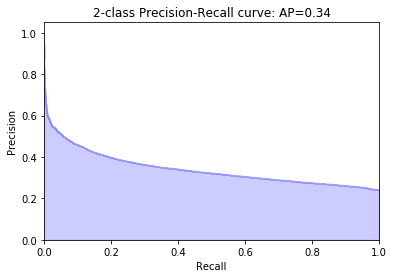

In [13]:
MAP_DQ_bert = plot_precision_recall_curve(df_eval['angdist_bert'].values, df_eval['is_same_intent'].values)
add_ev_res({'MAP_DQ':MAP_DQ_bert}, 'bert', bert_metadata)

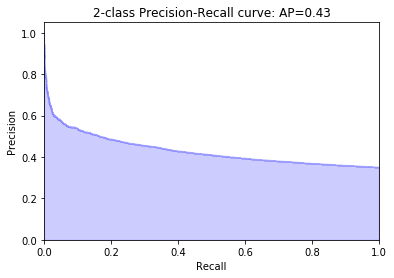

In [14]:
MAP_TP_bert = plot_precision_recall_curve(df_eval_by_angdist_bert['angdist_bert'].values, df_eval_by_angdist_bert['is_same_intent'].values)
add_ev_res({'MAP_TP':MAP_TP_bert}, 'bert', bert_metadata)   

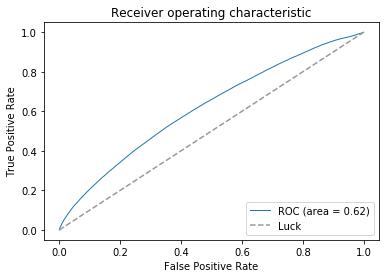

In [15]:
AUC_DQ_bert = plot_auc_curve(df_eval['angdist_bert'].values, df_eval['is_same_intent'].values)
add_ev_res({'AUC_DQ':AUC_DQ_bert}, 'bert', bert_metadata)   

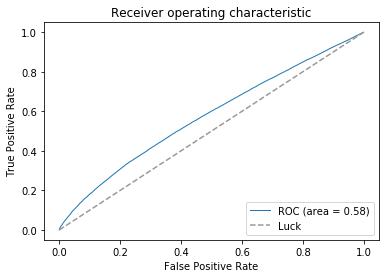

In [16]:
AUC_TP_bert = plot_auc_curve(df_eval_by_angdist_bert['angdist_bert'].values, df_eval_by_angdist_bert['is_same_intent'].values)
add_ev_res({'AUC_TP':AUC_TP_bert}, 'bert', bert_metadata)   

#### evaluate USE

In [113]:
%%time
angdist_use, cossim_use = sim_exact(np.stack(df_eval['text_emb_use_q'].values), np.stack(df_eval['text_emb_use'].values))
df_eval['angdist_use'] = angdist_use#.diagonal()
df_eval['cossim_use'] = cossim_use#.diagonal()
df_eval_res_by_angdist_use = df_eval.sort_values(by=['angdist_use'], ascending=False)[0:total_TP]

CPU times: user 16.8 s, sys: 16.6 s, total: 33.4 s
Wall time: 17.9 s


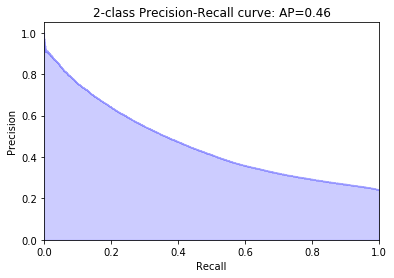

In [114]:
MAP_DQ_use = plot_precision_recall_curve(df_eval['angdist_use'].values, df_eval['is_same_intent'].values)
add_ev_res({'MAP_DQ':MAP_DQ_use}, 'use', use_metadata)   

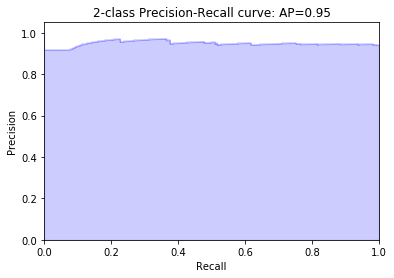

In [115]:
MAP_TP_use = plot_precision_recall_curve(df_eval_res_by_angdist_use['angdist_use'].values, df_eval_res_by_angdist_use['is_same_intent'].values)
add_ev_res({'MAP_TP':MAP_TP_use}, 'use', use_metadata)   

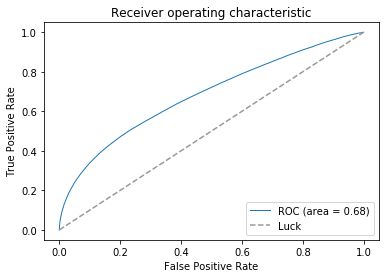

In [116]:
AUC_DQ_use = plot_auc_curve(df_eval['angdist_use'].values, df_eval['is_same_intent'].values)
add_ev_res({'AUC_DQ':AUC_DQ_use}, 'use', use_metadata)   

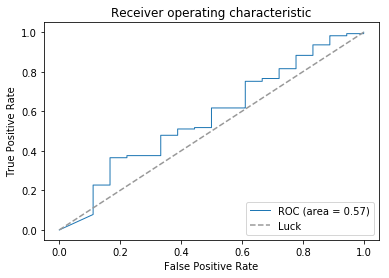

In [117]:
AUC_TP_use = plot_auc_curve(df_eval_res_by_angdist_use['angdist_use'].values, df_eval_res_by_angdist_use['is_same_intent'].values)
add_ev_res({'AUC_TP':AUC_TP_use}, 'use', use_metadata)   

#### save results

In [17]:
ev_results[5:]

[]

In [18]:
db.sts1_bert_use.insert_many(ev_results)

In [ ]:
server.stop()